In [ ]:
!pip install torch torchvision
!pip install ultralytics
!pip install diffusers

In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from ultralytics import YOLO
import os
from torch.utils.data import Dataset, DataLoader

In [ ]:
abs_path = '/content/drive/Othercomputers/MacBook Pro (Personal)/Documents/COLUMBIA UNIVERSITY/MSCS/Research/Knolling Bot/Preliminary Pipeline/'

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
yolo_model = YOLO('yolov8x.pt')
yolo_model.to(device)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(400, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_r

In [ ]:
def preprocess_image(image):
    image = image.convert("RGB") if isinstance(image, Image.Image) else Image.open(image).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor(),])
    image_tensor = transform(image).unsqueeze(0).to(device)

    return image, image_tensor

In [ ]:
def feat_from_image(image):
    image, image_tensor = preprocess_image(image)
    with torch.no_grad():
        results = yolo_model(image_tensor, verbose=False)

    threshold = 0.3
    results_data = results[0].boxes.data.cpu().numpy()
    filtered_data = [data for data in results_data if data[4] >= threshold]

    objects = []
    for data in filtered_data:
        x_min, y_min, x_max, y_max, conf, label = data
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
        width = x_max - x_min
        height = y_max - y_min
        area = width * height

        object_img = np.array(image)[y_min:y_max, x_min:x_max]
        avg_color = np.mean(object_img, axis=(0, 1)) if object_img.size > 0 else [0, 0, 0]
        avg_color = [int(c) for c in avg_color]

        perimeter = 2 * (width + height)
        roundness = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
        angle = np.arctan2(y_max - y_min, x_max - x_min) * 180 / np.pi

        obj = {
            'label': label,
            'bbox': (x_min, y_min, x_max, y_max),
            'width': width,
            'height': height,
            'avg_color': avg_color,
            'area': area,
            'roundness': roundness,
            'object_img': object_img,
            'rotation': angle
        }
        objects.append(obj)

    return objects

In [ ]:
class MessyTidyDataset(Dataset):
    def __init__(self, messy_images, tidy_images):
        self.messy_images = messy_images
        self.tidy_images = tidy_images

    def __len__(self):
        return len(self.messy_images)

    def __getitem__(self, idx):
        messy_image = self.messy_images[idx]
        tidy_image = self.tidy_images[idx]

        messy_objects = feat_from_image(messy_image)
        tidy_objects = feat_from_image(tidy_image)

        return messy_objects, tidy_objects

In [ ]:
messy_images_dir = abs_path + 'data/images_before_small/'
tidy_images_dir = abs_path + 'data/images_after_small/'

messy_images = [Image.open(os.path.join(messy_images_dir, filename)) for filename in sorted(os.listdir(messy_images_dir)) if filename.endswith(('.png', '.jpg'))]
tidy_images = [Image.open(os.path.join(tidy_images_dir, filename)) for filename in sorted(os.listdir(tidy_images_dir)) if filename.endswith(('.png', '.jpg'))]

dataset = MessyTidyDataset(messy_images, tidy_images)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
unet = UNet2DModel(
    sample_size=128,
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"
    ),
)

model = DDPMPipeline(unet=unet, scheduler=DDPMScheduler(num_train_timesteps=1000))
model.to(device)
optimizer = Adam(unet.parameters(), lr=1e-4)

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    unet.train()
    for messy_objects, tidy_objects in dataloader:
        optimizer.zero_grad()

        position_map = torch.zeros((1, 1, 128, 128), device=device)
        for obj in messy_objects:
            x_min, y_min, x_max, y_max = obj['bbox']
            position_map[:, :, y_min:y_max, x_min:x_max] = 1

        _, messy_image_tensor = preprocess_image(messy_images[0])

        input_tensor = torch.cat((messy_image_tensor, position_map), dim=1)

        noise = torch.randn_like(input_tensor).to(device)
        noisy_input = input_tensor + noise

        timestep = torch.randint(0, 1000, (1,), device=device).long()

        predicted_positions = unet(noisy_input, timestep).sample

        predicted_positions_adjusted = predicted_positions.clone()
        placed_map = torch.zeros((1, 1, 128, 128), device=device)

        tidy_position_map = torch.zeros((1, 1, 128, 128), device=device)
        for obj in tidy_objects:
            x_min, y_min, x_max, y_max = obj['bbox']
            tidy_position_map[:, :, y_min:y_max, x_min:x_max] = 1

        for obj_idx in range(predicted_positions.shape[1]):
            obj_mask = (predicted_positions[:, obj_idx, :, :] > 0.5).float()
            non_zero_indices = torch.nonzero(obj_mask, as_tuple=True)
            if len(non_zero_indices[0]) == 0:
                continue

            y_min, y_max = non_zero_indices[-2].min().item(), non_zero_indices[-2].max().item()
            x_min, x_max = non_zero_indices[-1].min().item(), non_zero_indices[-1].max().item()

            best_loss = float('inf')
            best_position = (x_min, y_min, x_max, y_max)
            for _ in range(100):
                x_min = random.randint(0, 128 - (x_max - x_min))
                y_min = random.randint(0, 128 - (y_max - y_min))
                x_max = x_min + (x_max - x_min)
                y_max = y_min + (y_max - y_min)

                temp_position_map = torch.zeros((1, 1, 128, 128), device=device)
                temp_position_map[:, :, y_min:y_max, x_min:x_max] = 1

                if y_max > y_min and x_max > x_min:
                    temp_loss = torch.nn.functional.mse_loss(temp_position_map[:, :, y_min:y_max, x_min:x_max], tidy_position_map[:, :, y_min:y_max, x_min:x_max])
                else:
                    temp_loss = float('inf')

                if temp_loss < best_loss:
                    best_loss = temp_loss
                    best_position = (x_min, y_min, x_max, y_max)

            x_min, y_min, x_max, y_max = best_position
            placed_map[:, :, y_min:y_max, x_min:x_max] = 1
            predicted_positions_adjusted[:, obj_idx, y_min:y_max, x_min:x_max] = obj_mask[:, y_min:y_max, x_min:x_max]

        loss = torch.nn.functional.mse_loss(predicted_positions_adjusted, tidy_position_map)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

model.save_pretrained(abs_path + 'trained_model/')

<ipython-input-11-78ebcd905760>:65: UserWarning: Using a target size (torch.Size([1, 1, 128, 128])) that is different to the input size (torch.Size([1, 4, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(predicted_positions_adjusted, tidy_position_map)


Epoch [1/50], Loss: 0.0446
Epoch [2/50], Loss: 0.0915
Epoch [3/50], Loss: 0.0121
Epoch [4/50], Loss: 0.0901
Epoch [5/50], Loss: 0.0392
Epoch [6/50], Loss: 0.0269
Epoch [7/50], Loss: 0.0232
Epoch [8/50], Loss: 0.0296
Epoch [9/50], Loss: 0.0343
Epoch [10/50], Loss: 0.0557
Epoch [11/50], Loss: 0.0511
Epoch [12/50], Loss: 0.0708
Epoch [13/50], Loss: 0.0347
Epoch [14/50], Loss: 0.0187
Epoch [15/50], Loss: 0.0120
Epoch [16/50], Loss: 0.0457
Epoch [17/50], Loss: 0.0873
Epoch [18/50], Loss: 0.0632
Epoch [19/50], Loss: 0.0687
Epoch [20/50], Loss: 0.0589
Epoch [21/50], Loss: 0.0570
Epoch [22/50], Loss: 0.0795
Epoch [23/50], Loss: 0.0394
Epoch [24/50], Loss: 0.0522
Epoch [25/50], Loss: 0.0832
Epoch [26/50], Loss: 0.0269
Epoch [27/50], Loss: 0.0285
Epoch [28/50], Loss: 0.0322
Epoch [29/50], Loss: 0.1138
Epoch [30/50], Loss: 0.0782
Epoch [31/50], Loss: 0.0375
Epoch [32/50], Loss: 0.0303
Epoch [33/50], Loss: 0.0518
Epoch [34/50], Loss: 0.0720
Epoch [35/50], Loss: 0.0771
Epoch [36/50], Loss: 0.0462
E

In [ ]:
def bbox_from_tensor(new_bbox, obj_width, obj_height):
    y_center, x_center = np.unravel_index(np.argmax(new_bbox), new_bbox.shape)

    x_min = max(0, x_center - obj_width // 2)
    x_max = min(new_bbox.shape[1], x_center + obj_width // 2)
    y_min = max(0, y_center - obj_height // 2)
    y_max = min(new_bbox.shape[0], y_center + obj_height // 2)

    return x_min, y_min, x_max, y_max

def generate_tidy_image(messy_image):
    import matplotlib.pyplot as plt
    with torch.no_grad():
        messy_objects = feat_from_image(messy_image)

        position_map = torch.zeros((1, 1, 128, 128), device=device)
        for obj in messy_objects:
            x_min, y_min, x_max, y_max = obj['bbox']
            position_map[:, :, y_min:y_max, x_min:x_max] = 1

        _, messy_image_tensor = preprocess_image(messy_image)

        input_tensor = torch.cat((messy_image_tensor, position_map), dim=1)

        timestep = torch.tensor([500], device=device).long()

        tidy_position_map = model.unet(input_tensor, timestep).sample.squeeze(0)

        background_color = np.median(np.array(messy_image), axis=(0, 1)).astype(int)
        tidy_image = np.full((128, 128, 3), background_color, dtype=np.uint8)
        placed_map = np.zeros((128, 128), dtype=np.uint8)
        for obj, new_bbox in zip(messy_objects, tidy_position_map.squeeze().cpu().numpy()):
            x_min, y_min, x_max, y_max = bbox_from_tensor(new_bbox, obj['width'], obj['height'])

            attempts = 0
            max_attempts = 100
            while np.sum(placed_map[y_min:y_max, x_min:x_max]) > 0 and attempts < max_attempts:
                min_distance = float('inf')
                best_position = (x_min, y_min)
                for i in range(0, 128 - obj['height']):
                    for j in range(0, 128 - obj['width']):
                        if np.sum(placed_map[i:i + obj['height'], j:j + obj['width']]) == 0:
                            distance = np.sqrt((i - y_min) ** 2 + (j - x_min) ** 2)
                            if distance < min_distance:
                                min_distance = distance
                                best_position = (j, i)

                x_min, y_min = best_position
                x_max = x_min + obj['width']
                y_max = y_min + obj['height']
                attempts += 1


            if attempts == max_attempts:
                continue

            placed_map[y_min:y_max, x_min:x_max] = 1


            obj_img = obj['object_img']

            if x_max > x_min and y_max > y_min:
                obj_img_resized = cv2.resize(obj_img, (x_max - x_min, y_max - y_min))
                tidy_image[y_min:y_max, x_min:x_max] = obj_img_resized

    return Image.fromarray(tidy_image)

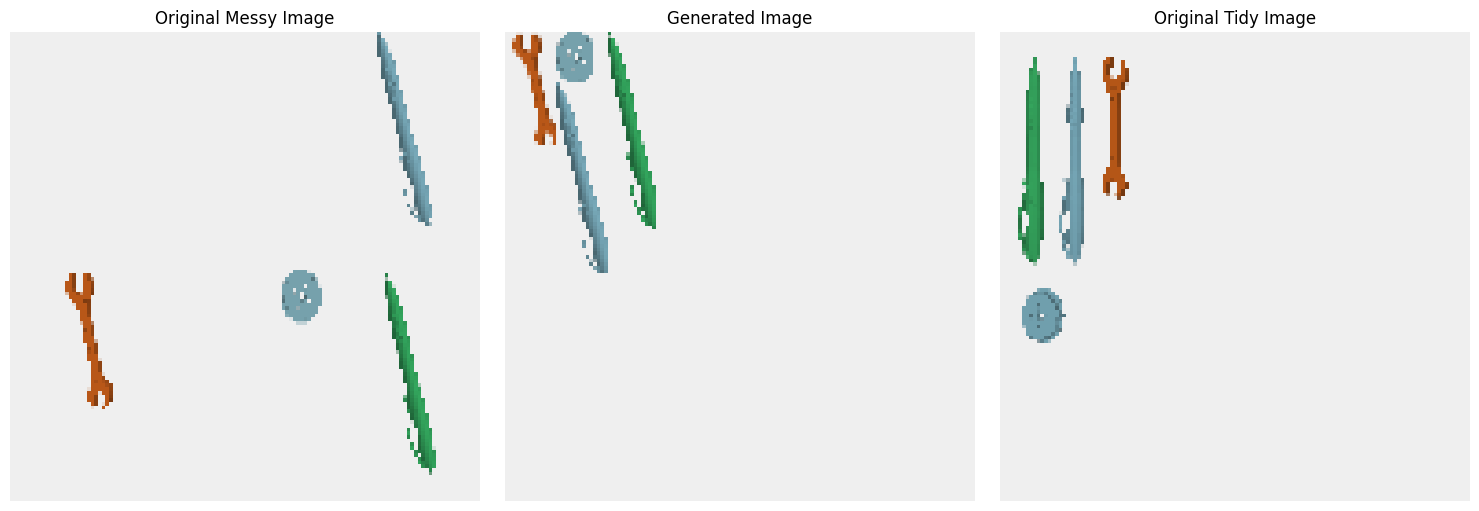

In [ ]:
img_id = 1

generated_image = generate_tidy_image(messy_images[img_id])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(messy_images[img_id])
axes[0].set_title("Original Messy Image")
axes[0].axis('off')

axes[1].imshow(generated_image)
axes[1].set_title("Generated Image")
axes[1].axis('off')

axes[2].imshow(tidy_images[img_id])
axes[2].set_title("Original Tidy Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()

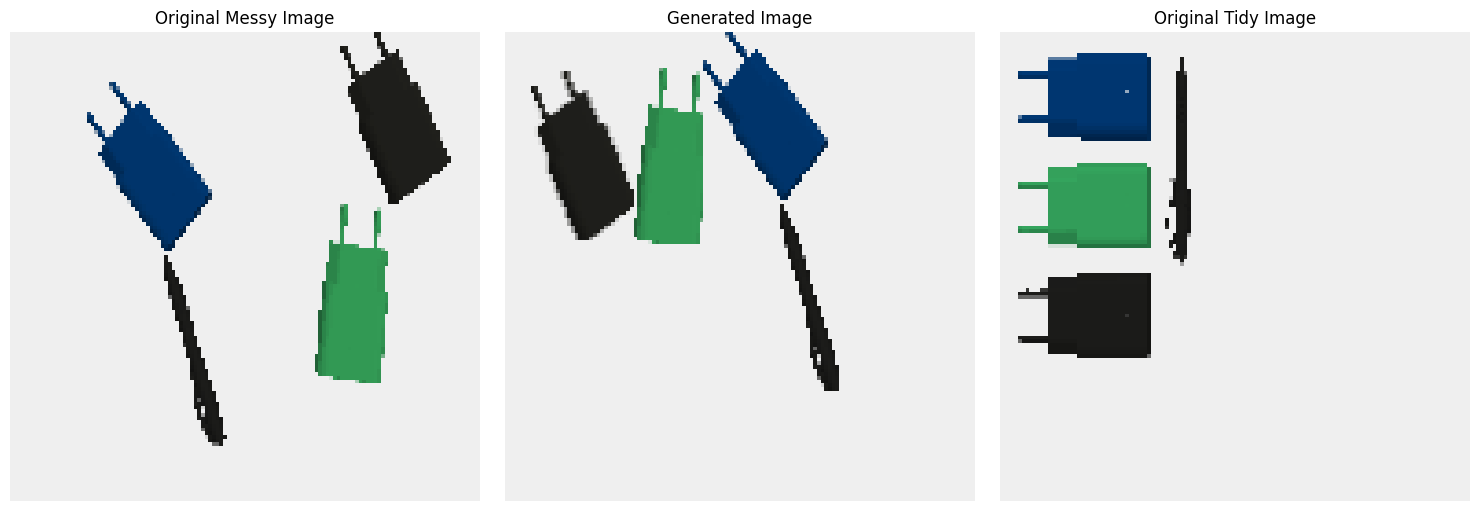

In [ ]:
img_id = 6

generated_image = generate_tidy_image(messy_images[img_id])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(messy_images[img_id])
axes[0].set_title("Original Messy Image")
axes[0].axis('off')

axes[1].imshow(generated_image)
axes[1].set_title("Generated Image")
axes[1].axis('off')

axes[2].imshow(tidy_images[img_id])
axes[2].set_title("Original Tidy Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()

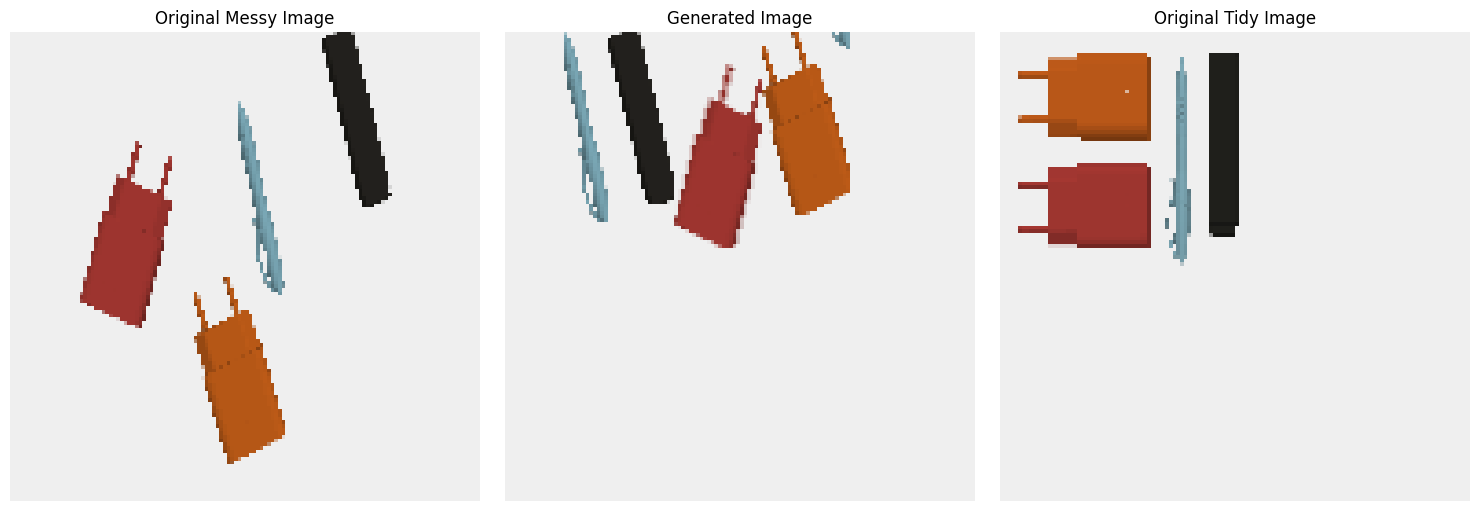

In [ ]:
img_id = 16

generated_image = generate_tidy_image(messy_images[img_id])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(messy_images[img_id])
axes[0].set_title("Original Messy Image")
axes[0].axis('off')

axes[1].imshow(generated_image)
axes[1].set_title("Generated Image")
axes[1].axis('off')

axes[2].imshow(tidy_images[img_id])
axes[2].set_title("Original Tidy Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()